In [ ]:
# Install necessary packages
!pip install huggingface_hub
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [ ]:

# Relevant imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch


In [ ]:
# Load data
df = pd.read_csv('/content/Extended_Course_Feedback_Dataset.csv')

In [ ]:
# Replacing text labels with numerical values
label_mapping = {
    'very positive': 5,
    'positive': 4,
    'neutral': 3,
    'negative': 2,
    'very negative': 1
}

In [ ]:
df['LABEL'].replace(label_mapping, inplace=True)

In [ ]:
df['LABEL'] = df['LABEL'] - 1

In [ ]:
# Renaming columns
df = df.rename(columns={'COMMENT': 'text', 'LABEL': 'labels'})

In [ ]:
# Splitting data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.25, random_state=42)

In [ ]:
# Preparing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenizing the data
train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, max_length=512)

In [ ]:
# Converting the data into datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test.tolist()
})

In [ ]:
# Loading the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.483600,0.380578
2,0.032600,0.126942
3,0.090500,0.146109


TrainOutput(global_step=564, training_loss=0.4725921904645094, metrics={'train_runtime': 1850.6169, 'train_samples_per_second': 2.432, 'train_steps_per_second': 0.305, 'total_flos': 43938674181000.0, 'train_loss': 0.4725921904645094, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Precision: {results['eval_precision']}")
print(f"Recall: {results['eval_recall']}")
print(f"F1 Score: {results['eval_f1']}")


Accuracy: 0.976
Precision: 0.9764965542850673
Recall: 0.976
F1 Score: 0.9760704864362149


In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis = 1)

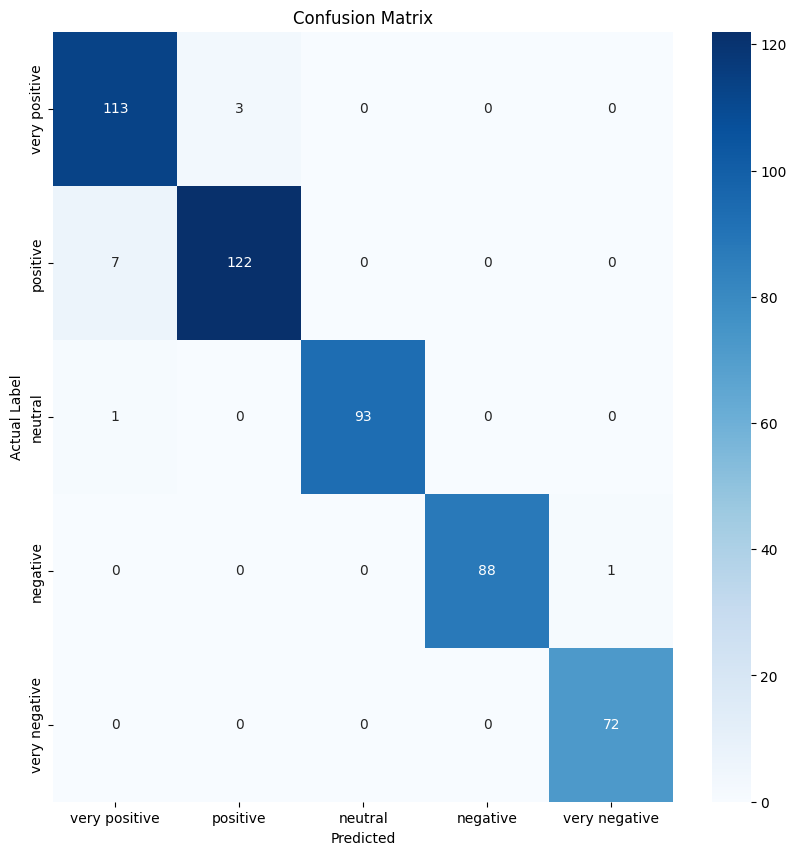

In [ ]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt ='d', cmap='Blues',xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
model.save_pretrained('/content/model')
tokenizer.save_pretrained('/content/tokenizer')

In [ ]:
def predict_sentiment(comment: str):
    # Tokenize the input comment
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the label with the highest probability
    predicted_label = torch.argmax(logits, dim=1).item()

    # Map the predicted label to the sentiment
    label_mapping = {0: 'very negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'very positive'}
    sentiment = label_mapping.get(predicted_label, "Unknown")

    return sentiment


In [ ]:
comment = input("Enter a comment: ")
predicted_sentiment = predict_sentiment(comment)
print(f"Predicted Sentiment: {predicted_sentiment}")

Enter a comment: hated the class completely. Always felt disgusted going for class. Didn't enjoy the experience at all
Predicted Sentiment: very negative


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/Colab Notebooks', exist_ok = True)
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/model')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/tokenizer')
print("Model and tokenizer have been saved")

Model and tokenizer have been saved
